In [29]:
from pprint import pprint
from matplotlib import pyplot as plt
import cv2
import copy
import operator
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, ZeroPadding2D, MaxPooling2D
from keras.callbacks import TensorBoard
from keras.models import load_model
from keras.optimizers import Adam
import time
import json
import os
import warnings
import math

%matplotlib notebook

warnings.filterwarnings(action='ignore')

In [30]:
def read_jsons(folder):
    jsons = [json for json in os.listdir(folder) if json.endswith(".json")]
    
    return jsons

In [31]:
def generateRandomPoint():
    return np.random.randint(1080, size = (25, 2))

In [32]:
def generateRandomLength():
    return np.random.randint(200,500, size = 1)

In [33]:
def getNewLocations(index, distances, scaler, original, finalPoints, first):
    k = 0
    
    while k < 30:
        for j in range(len(distances)):
            if k == 30:
                break
                
            tmp = copy.deepcopy(original)
            
            for x in range(original.shape[0]):
                if index < 2:
                    tmp[x][index] = tmp[x][index] + (distances[j] * scaler)
                
                if index == 2:
                    tmp[x][0] = tmp[x][0] + distances[j]
                    tmp[x][1] = tmp[x][1] + distances[j]
                
                if index == 3:
                    tmp[x][0] = tmp[x][0] + distances[j]
                    tmp[x][1] = tmp[x][1] - distances[j]
                
                if index == 4:
                    tmp[x][0] = tmp[x][0] - distances[j]
                    tmp[x][1] = tmp[x][1] + distances[j]
                
                if index == 5:
                    tmp[x][0] = tmp[x][0] - distances[j]
                    tmp[x][1] = tmp[x][1] - distances[j]
                    
            if not first:
                finalPoints = np.concatenate((finalPoints, tmp), axis = 0)
            else:
                finalPoints = copy.deepcopy(tmp)
                first = False
                
            k += 1

    return finalPoints, first

In [34]:
def generateTrainingData():
    
    frequencies = np.linspace(3, 15, 13, dtype=int)
    
    k = 0
    l  = 0
    
    for j in range(5000, 10000):
        original = generateRandomPoint()
        distance = generateRandomLength()
        
        finalPoints = []
        y_points = []
        first = True
        
        l += 1
        
        for i in range(len(frequencies)):
            frequency = frequencies[i]

            div = int(math.floor(frequency / 2)) + frequency % 2
            
            first_half = np.linspace(0, distance, div, dtype = int)
            second_half = np.linspace(distance, 0, div, dtype = int)
            
            if frequency % 2 == 1:
                second_half = second_half[1:]
            else:
                first_half = first_half[:-1]

            distances = np.concatenate((first_half, second_half), axis = 0)
            

            finalPoints, first = getNewLocations(0, distances, 1, original, finalPoints, first)

            finalPoints, first = getNewLocations(0, distances, -1, original, finalPoints, first)

            finalPoints, first = getNewLocations(1, distances, 1, original, finalPoints, first)

            finalPoints, first = getNewLocations(1, distances, -1, original, finalPoints, first)
            
            finalPoints, first = getNewLocations(2, distances, -1, original, finalPoints, first)

            finalPoints, first = getNewLocations(3, distances, -1, original, finalPoints, first)

            finalPoints, first = getNewLocations(4, distances, -1, original, finalPoints, first)

            finalPoints, first = getNewLocations(5, distances, -1, original, finalPoints, first)

            y_points = np.append(y_points, frequency)
            y_points = np.append(y_points, frequency)
            y_points = np.append(y_points, frequency)
            y_points = np.append(y_points, frequency)
            y_points = np.append(y_points, frequency)
            y_points = np.append(y_points, frequency)
            y_points = np.append(y_points, frequency)
            y_points = np.append(y_points, frequency)
            
        with open('Repetition/RepetitionData' + str(j) + '.json', 'w') as fp:
            json.dump(dict(enumerate(finalPoints.tolist())), fp)
            
        with open('RepetitionResult/RepetitionResult' + str(j) + '.json', 'w') as fp:
            json.dump(dict(enumerate(y_points.tolist())), fp)
                
#     return finalPoints.reshape(13 * l * 8, 30, 50, 1), y_points    

In [35]:
def read_data(jsons, folder):
    data_points = []
    
    for i in range(len(jsons)):
        
        with open((folder + jsons[i])) as f:
            data = json.load(f)
            
        for k in data:
            data_points.append(data[k])
            
    return data_points

In [36]:
def loadGeneratedData(jsons, folder):
            
    data = read_data(jsons, folder)
    
    return data

In [37]:
def returnBatch(x_jsons, y_jsons):
    x_batch = x_jsons[:10]
    y_batch = y_jsons[:10]
    
    x_remain = x_jsons[10:]
    y_remain = y_jsons[10:]
    
    return x_batch, y_batch, x_remain, y_remain

In [38]:
def modelCreation():
    model = Sequential()
    model.add(Conv2D(128, kernel_size = 5, activation = 'relu', input_shape = (30, 50, 1)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size = 4, activation = 'relu'))

    model.add(ZeroPadding2D((1,1)))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, kernel_size = 3, activation = 'relu'))

    model.add(ZeroPadding2D((1,1)))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size = (8,8), strides = (3,3)))
    model.add(Flatten())
    model.add(Dense(16, activation='softmax'))
    
    model.compile(optimizer = Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [39]:
def trainModel(model, x_jsons, y_jsons):
    
    length = len(x_jsons)
    
    acc = []
    loss = []
    val_acc = []
    val_loss = []
    x_axis = []
    time_val = 0
    
    fig = plt.figure()
    ax = fig.add_subplot(221)
    ab = fig.add_subplot(222)
    ac = fig.add_subplot(223)
    ad = fig.add_subplot(224)
    ax.set_title('Acc')
    ab.set_title('Loss')
    ac.set_title('Val_acc')
    ad.set_title('Val_loss')
    plt.ion()
    
    fig.show()
    fig.canvas.draw()
    
    original_x_jsons = copy.deepcopy(x_jsons)
    original_y_jsons = copy.deepcopy(y_jsons)
    
    for i in range(2):
        
        x_jsons = copy.deepcopy(original_x_jsons)
        y_jsons = original_y_jsons
        k = 0
        
        while k != length:
            x_data, y_data, x_jsons, y_jsons = returnBatch(x_jsons, y_jsons)

            k += 10

            x_raw = loadGeneratedData(x_data, 'Repetition/')
            y_raw = loadGeneratedData(y_data, 'RepetitionResult/')

            X = np.array(x_raw)
            Y = np.array(y_raw)

            X = X.reshape(1040, 30, 50, 1)
            Y = Y.reshape(1040, 1)

            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 101)

            y_train = to_categorical(y_train)
            y_test = to_categorical(y_test)

            history = model.fit(X_train, y_train, validation_data =(X_test, y_test), epochs=100, verbose=False)

            acc.append(history.history['acc'][-1])
            loss.append(history.history['loss'][-1])
            val_acc.append(history.history['val_acc'][-1])
            val_loss.append(history.history['val_loss'][-1])

            ax.clear()
            ab.clear()
            ac.clear()
            ad.clear()
            ax.set_title('Acc')
            ab.set_title('Loss')
            ac.set_title('Val_acc')
            ad.set_title('Val_loss')
            ax.plot(acc, '-o')
            ab.plot(loss,'-o')
            ac.plot(val_acc,'-o')
            ad.plot(val_loss,'-o')
            fig.canvas.draw()
            time.sleep(0.5)


            model.save('model/repetition.h5')

In [41]:
generateTrainingData()

In [14]:
x_jsons = read_jsons('Repetition/')
y_jsons = read_jsons('RepetitionResult/')

In [15]:
len(y_jsons)

14910

In [16]:
model = modelCreation()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


<IPython.core.display.Javascript object>


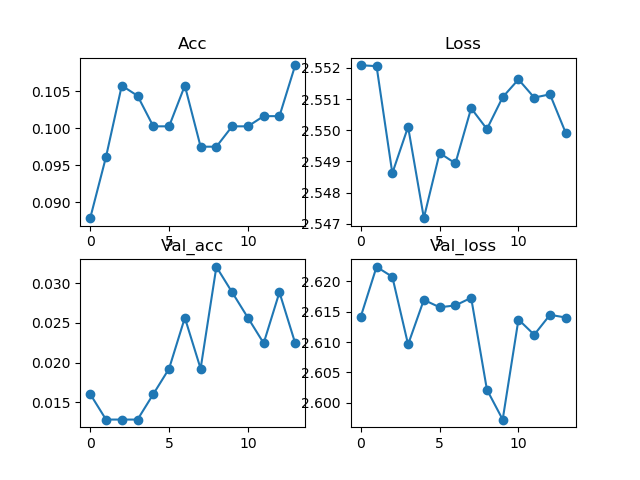

Instructions for updating:
Use tf.cast instead.


KeyboardInterrupt: 

In [17]:
trainModel(model, x_jsons, y_jsons)